# FORESEE - ALP with W couplings

### Load Libraries 

In [1]:
import numpy as np
import sys
import os
src_path = "/Users/felixkling/Documents/GitHub/FORESEE/"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

If dark photons are sufficiently light, they are mainly produced via pion decay. To start, let us have a look at the pion spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi^0$, $\eta$, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. 

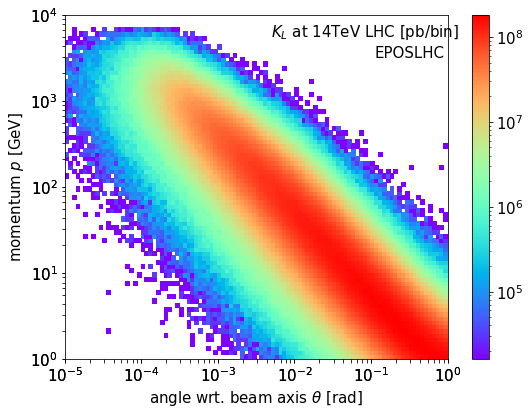

In [3]:
plot=foresee.get_spectrumplot(pid="130", generator="EPOSLHC", energy="14", prange=[[-5, 0, 100],[ 0, 4, 80]])
plot.text(-2.3,3.75, r"$K_L$ at 14TeV LHC [pb/bin]",fontsize=15,color="k",rotation=0)
plot.text(-0.95,3.5, r"EPOSLHC",fontsize=15,color="k",rotation=0)
plot.subplots_adjust(left=0.10, right=1.05, bottom=0.10, top=0.97)
plot.savefig("/Users/felixkling/Downloads/Figure.pdf")
plot.show()

## 2. Specifying the Model: Dark Photons

The phenomenology of the ALP with $W$-couplings can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = - \frac{1}{2} m_{a}^2 a^2  - \frac{g_{aWW}}{4}a W^a_{\mu\nu} \tilde W^a_{\mu\nu}
\end{equation}

with the ALP mass $a$ and the coupling parameter $g_{aWW}$ as free parameters. For the search for ALPS at forward experiments we need to know i) the *production rate*, ii) the *lifetime* and iii) possibly the *decay branching fractions* of dark photons as function of those two parameters. All properties are specified in the `Model` class. We initialize it with the name of the model as argument. 

In [4]:
energy = "14"
modelname="ALP-W"
model = Model(modelname)

**Production** Most LLPs are produced in the decay of primary particles. Here we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. We additionally specify the variable `nsample` which specifies how often each parent particle is decayed. 

For the ALP, we have the branching fractions (with $g = g_{aWW}\cdot GeV$)

\begin{equation}
    \text{BR}(K^+ \to \pi^+ a) = 10.5 \times g^2 \times [(1-(m_\pi+m_a)^2/m_K^2)(1-(m_\pi-m_a)^2/m_K^2)]^{1/2}
\end{equation}
\begin{equation}
\text{BR}(K_L \to \pi^0 a) = 4.5 \times g^2 \times [(1-(m_\pi+m_a)^2/m_K^2)(1-(m_\pi-m_a)^2/m_K^2)]^{1/2}
\end{equation}
\begin{equation}
\text{BR}(b \to X_s a)     = 2.2 \cdot 10^4 \times g^2 \times [(1-(m_K+m_a)^2/m_B^2)(1-(m_K-m_a)^2/m_B^2)]^{1/2}
\end{equation}

In [5]:
model.add_production_2bodydecay(
    pid0 = "5",
    pid1 = "321",
    br = "2.2e4 * coupling**2 * np.sqrt((1-(mass+0.495)**2/5.279**2)*(1-(mass-0.495)**2/5.279**2))",
    generator = "Pythia8",
    energy = energy,
    nsample = 200,
)

model.add_production_2bodydecay(
    pid0 = "-5",
    pid1 = "321",
    br = "2.2e4 * coupling**2 * np.sqrt((1-(mass+0.495)**2/5.279**2)*(1-(mass-0.495)**2/5.279**2))",
    generator = "Pythia8",
    energy = energy,
    nsample = 200,
)

model.add_production_2bodydecay(
    pid0 = "130",
    pid1 = "111",
    br = "4.5 * coupling**2 * np.sqrt((1-(mass+0.135)**2/0.495**2)*(1-(mass-0.135)**2/0.495**2))",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10,
)

model.add_production_2bodydecay(
    pid0 = "321",
    pid1 = "211",
    br = "10.5 * coupling**2 * np.sqrt((1-(mass+0.135)**2/0.495**2)*(1-(mass-0.135)**2/0.495**2))",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10,
)

model.add_production_2bodydecay(
    pid0 = "-321",
    pid1 = "211",
    br = "10.5 * coupling**2 * np.sqrt((1-(mass+0.135)**2/0.495**2)*(1-(mass-0.135)**2/0.495**2))",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10,
)

**Lifetime:** For most models the lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

In [6]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
    coupling_ref=1
)

**Branching Fractions:** For most models, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and brnaching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [7]:
model.set_br_1d(
    modes=["gamma_gamma"],
    filenames=["model/br/gamma_gamma.txt"]
)

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [8]:
foresee.set_model(model=model)

Let's first look at one benchmark scenario with $m_{a}=200$ MeV and $g=10^{-4}$ using the function `foresee.get_llp_spectrum()`.  By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

save data to file: ./model/LLP_spectra/14TeV_5_m_0.01.npy


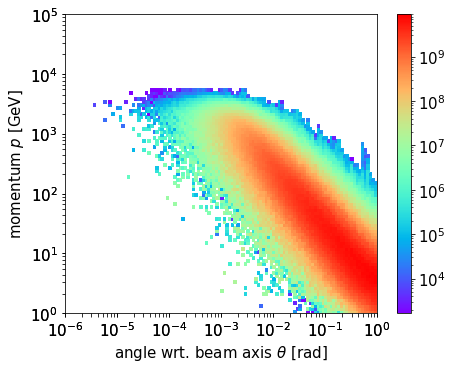

In [22]:
plt = foresee.get_llp_spectrum(0.01, coupling=1, do_plot=True, save_file=True)
plt.show()

save data to file: ./model/LLP_spectra/14TeV_5_m_0.1.npy


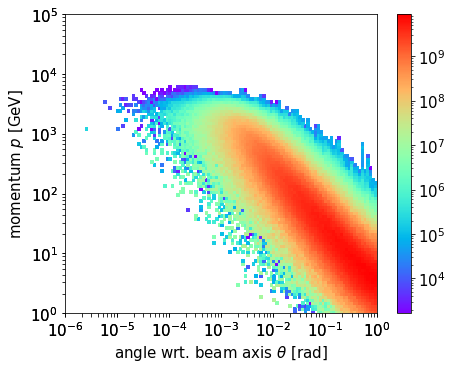

In [23]:
plt = foresee.get_llp_spectrum(0.1, coupling=1, do_plot=True, save_file=True)
plt.show()

We can now produce a set of LLP spectra for various masses and unit coupling and save them.  

In [10]:
masses = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]
masses = [0.2]
for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: model/LLP_spectra/14TeV_5_m_0.2.npy
save data to file: model/LLP_spectra/14TeV_-5_m_0.2.npy
save data to file: model/LLP_spectra/14TeV_130_m_0.2.npy
save data to file: model/LLP_spectra/14TeV_321_m_0.2.npy


## 4. Count Eventrate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [24]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< .1", 1.5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific ALP mass $m_a=200$ MeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [25]:
output = foresee.get_events(mass=0.2, energy=energy, couplings = np.logspace(-8,-2,7), )
coups, ctaus, nsigs, energies, weights, _ = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsig =", '{:5.3e}'.format(nsig))

epsilon = 1.000e-08 : nsig = 1.712e-11
epsilon = 1.000e-07 : nsig = 1.712e-07
epsilon = 1.000e-06 : nsig = 1.710e-03
epsilon = 1.000e-05 : nsig = 1.516e+01
epsilon = 1.000e-04 : nsig = 4.308e+02
epsilon = 1.000e-03 : nsig = 2.989e-67
epsilon = 1.000e-02 : nsig = 0.000e+00


The previous function also outputs the energy distribution of the dark photons which decay inside the detector. Let's have a look at them.

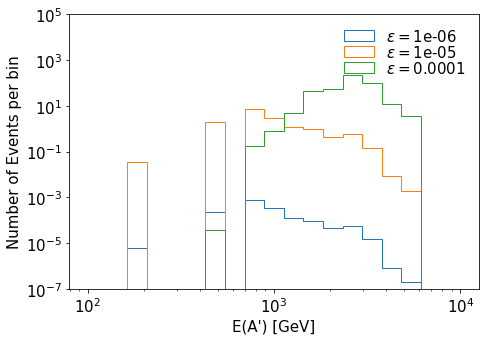

In [26]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
for coup,en,weight in zip(coups,energies,weights):
    if sum(weight)<10**-5 : continue
    ax.hist(en, weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$\epsilon=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-7,10**5) 
    ax.set_xlabel("E(A') [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

### Debug

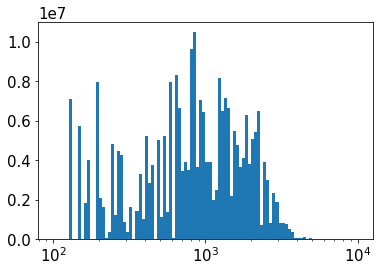

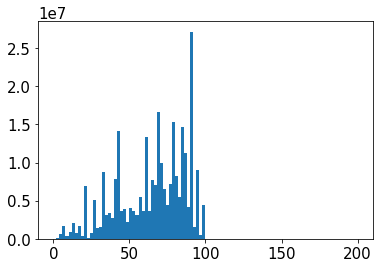

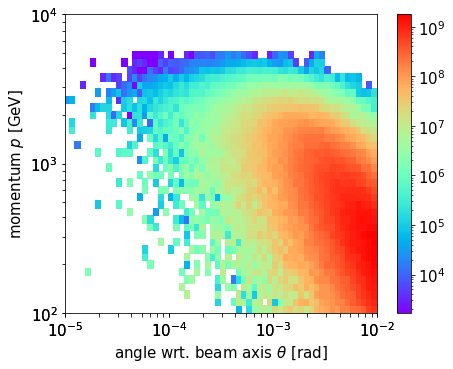

In [28]:
ps,ws=foresee.convert_list_to_momenta("model/LLP_spectra/14TeV_5_m_0.01.npy", filetype="npy", mass=0.01)
lp,lr,lw=[],[],[]
for p,w in zip(ps,ws):
    r=np.sqrt(p.px**2+p.py**2)/p.pz*480*1000
    if r>100: continue
    lp.append(p.e)
    lr.append(r)
    lw.append(w)
plt.hist(lp,weights=lw,bins=np.logspace(2,4,101))
plt.xscale("log")
plt.show()
plt.hist(lr,weights=lw,bins=np.linspace(0,200,101))
plt.show()
_=foresee.convert_to_hist_list(ps,ws, do_plot=True, prange=[[-5, -2, 60],[ 2, 4, 40]])

    

In [38]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + (x.y)**2)<.1", 1.5, 1/1000., None
foresee.set_detector(distance=distance, selection=selection, length=length, 
                     luminosity=luminosity, channels=channels)

weighted, weights, unweighted = foresee.write_events(filename="model/events/test.hepmc", mass=.1, 
                     coupling=1e-4, energy="14", numberevent=1000, zfront=0, notime=True, seed=1234,
                     modes = ["5"], nsample=100, return_data=True)
unweighted=np.array(unweighted)

/Users/felixkling/Documents/GitHub/FORESEE/src/foresee.py:911: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  channels=np.array(channels).T


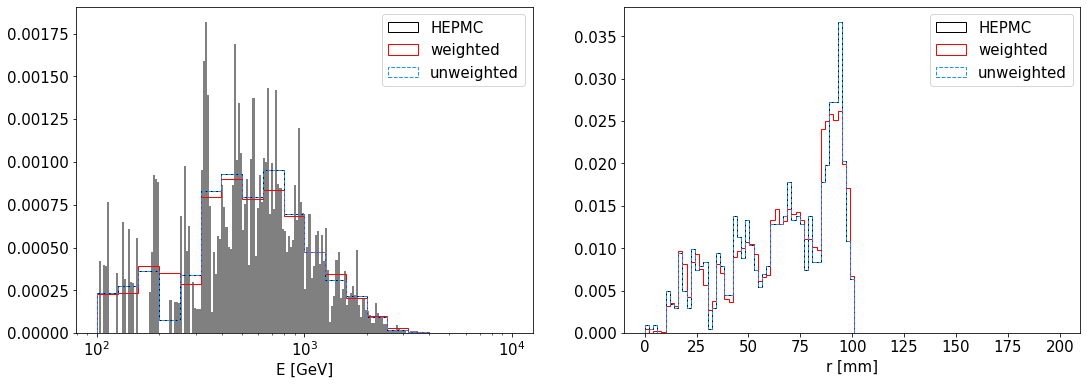

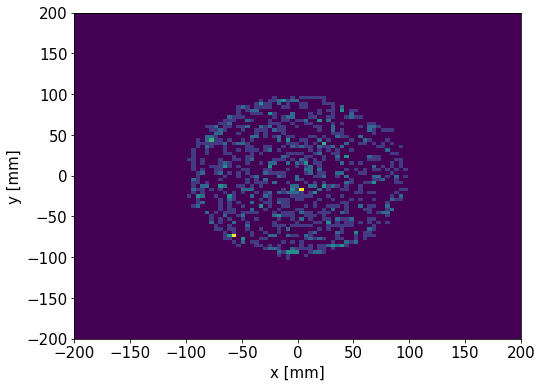

In [39]:
# raw data
evals_wgt, rvals_wgt = np.array(weighted[:,0]),np.array(weighted[:,1])*480*1000
evals_unw, rvals_unw = np.array(unweighted[:,0]),np.array(unweighted[:,1])*480*1000

# hepmc file
evals,xvals,yvals,rvals = [],[],[],[]
with open("model/events/test.hepmc") as f:
    for line in f:
        #print (line)
        if len(line)==0 or line[0]=="#": continue

        if line[0]=="V":
            words = [elt.strip() for elt in line.split( )]
            x,y,z = float(words[3]), float(words[4]), float(words[5])
            xvals.append(x)
            yvals.append(y)
            rvals.append(np.sqrt(y**2+x**2))
        
        if line[0]=="P" and line[4]=="3":
            words = [elt.strip() for elt in line.split( )]
            px,py,pz,en = float(words[3]), float(words[4]), float(words[5]), float(words[6])
            evals.append(en)
        

fig = plt.figure(figsize=(18,6))

ax = plt.subplot(1,2,1)
ax.hist(evals    , bins=np.logspace(2,4,201),                 density=True, color="gray")
ax.hist(evals    , bins=np.logspace(2,4,21) ,histtype="step", density=True, color="k", label="HEPMC")
ax.hist(evals_wgt, bins=np.logspace(2,4,21) ,histtype="step", density=True, color="red", label="weighted", weights=weights)
ax.hist(evals_unw, bins=np.logspace(2,4,21) ,histtype="step", density=True, color="dodgerblue", ls="dashed", label="unweighted")
ax.set_xscale("log")
ax.set_xlabel("E [GeV]")
ax.legend()

ax = plt.subplot(1,2,2)
ax.hist(rvals    , bins=np.linspace(0,200,100), histtype="step", density=True, color="k", label="HEPMC")
ax.hist(rvals_wgt, bins=np.linspace(0,200,100), histtype="step", density=True, color="red", label="weighted", weights=weights)
ax.hist(rvals_unw, bins=np.linspace(0,200,100), histtype="step", density=True, color="dodgerblue", ls="dashed", label="unweighted")
ax.set_xlabel("r [mm]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.hist2d(xvals,yvals, bins=(np.linspace(-200,200,100),np.linspace(-200,200,100)))
plt.show()

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 reach for ALPs. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

In [13]:
# masses
masses = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 
]

- the nominal/default setup

In [15]:
#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy, couplings = np.logspace(-8,-2,61))
    list_nevents.append(nevents)  
    
#save results
np.save("model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [14]:
setups = [
    ["14TeV_default.npy",    "default"  , "red",     "solid", 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

In [15]:
bounds = [   
    ["bounds_SN1987.txt",      "SN1987",  0.100, 1.9*10**-7, 25  ],
    ["bounds_E137.txt",        "E137",    0.100, 1.2*10**-6, -8  ],
    ["bounds_LEP.txt",         "LEP",     4.000, 6.7*10**-4, 0   ],
    ["bounds_E949_displ.txt",  "E949",    0.065, 9.0*10**-5, -9  ],
    ["bounds_NA62_1.txt",      "NA62",    0.235, 4.5*10**-4, 90  ],
    ["bounds_NA62_2.txt",      "NA62",    0.065, 9.2*10**-6, 2   ],
    ["bounds_KOTO.txt",        "KOTO",    0.090, 3.4*10**-5, 2   ],
    ["bounds_KTEV.txt",        "KTEV",    0.200, 4.5*10**-4, 90  ],
    ["bounds_NA6264.txt",      "NA64",    0.270, 4.5*10**-4, 90  ],
    ["bounds_E949_prompt.txt", "E949",    0.065, 3.0*10**-6, -5  ],
    ["bounds_CDF.txt",         "CDF",     0.065, 7.5*10**-4, -12 ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [16]:
projections = [
    ["limits_Belle2-3gamma.txt",   "royalblue",   r"Belle2 $3\gamma$"  , 1.400, 1.7*10**-4, 0  ],
    ["limits_KOTO-2gamma.txt",     "cyan",        r"KOTO $2\gamma$"    , 0.060, 2.0*10**-4, 0  ],
    ["limits_KOTO-4gamma.txt",     "blue",        r"KOTO $4\gamma$"    , 0.370, 3.0*10**-4, 0  ],
    ["limits_NA62-0gamma1.txt",    "dodgerblue",  r"NA62 $0\gamma$"    , 0.220, 2.0*10**-5, 0  ],
    ["limits_NA62-0gamma2.txt",    "dodgerblue",  None                 , 0    , 0         , 0  ],
    ["limits_NA62-2gamma.txt",     "deepskyblue", r"NA62 $2\gamma$"    , 0.370, 1.0*10**-4, 0  ],
    ["limits_LHC.txt",             "teal",        r"LHC $Z\to3\gamma$" , 2.500, 3.5*10**-6, 0  ],
]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

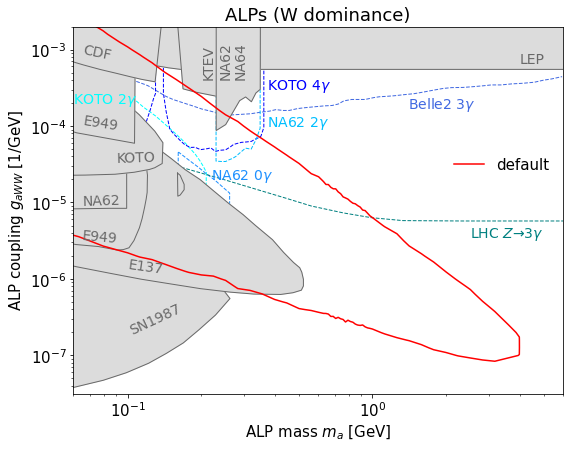

In [17]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="ALPs (W dominance)", 
    xlims = [0.06,6], 
    ylims=[10**-7.5,0.002],
    xlabel=r"ALP mass $m_{a}$ [GeV]", 
    ylabel=r"ALP coupling $g_{aWW}$ [1/GeV]",
    legendloc=(1,0.68),
    figsize=(8,6),
)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("/Users/felixkling/Downloads/Figure.pdf")
plot.show()